## Applying and Evaluating Neural Net Architecture From "End-to-End Multi-View Networks for Text Classification"

by Evan Baker



In this notebook, I'll go through some simple EDA for the dataset provided by HumanAPI, and apply the multi-view neural network architecture from the article mentioned in the title to classifying the data.

In [100]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [101]:
# let's see how many files we're working with

# quite a bit of class imbalance in the training data

for data_dir in os.listdir('./dataset/')[1:]:
    print data_dir, ": count of files = ", len(os.listdir('./dataset/%s' % data_dir))

train_neg : count of files =  1875
train_pos : count of files =  12500
valid_neg : count of files =  6250
valid_pos : count of files =  6250


In [103]:
!ls ./dataset/train_neg

10003_1.txt 11918_2.txt 2564_2.txt  4419_3.txt  6282_4.txt  8094_2.txt
10021_2.txt 11925_2.txt 2566_1.txt  4423_2.txt  6289_1.txt  8102_1.txt
10030_1.txt 11939_4.txt 2567_3.txt  4426_1.txt  6301_4.txt  8115_1.txt
10035_1.txt 11943_1.txt 2577_2.txt  4437_1.txt  6304_1.txt  8119_3.txt
1004_4.txt  11945_3.txt 258_4.txt   4453_3.txt  630_2.txt   8126_3.txt
10054_1.txt 11948_2.txt 2592_3.txt  4467_1.txt  6320_1.txt  8128_1.txt
10058_1.txt 1194_1.txt  2595_3.txt  4471_4.txt  6321_3.txt  8133_1.txt
10064_3.txt 1195_1.txt  25_1.txt    4475_1.txt  6323_1.txt  8144_3.txt
10066_4.txt 11961_1.txt 2611_3.txt  4480_1.txt  6327_4.txt  8148_1.txt
10067_3.txt 11964_4.txt 2629_4.txt  4482_2.txt  6328_4.txt  8152_2.txt
10077_2.txt 11976_1.txt 2633_1.txt  4484_1.txt  6336_4.txt  8157_4.txt
1007_1.txt  11980_4.txt 2634_4.txt  4493_1.txt  6345_1.txt  8160_1.txt
10086_2.txt 11985_3.txt 2636_1.txt  4495_2.txt  6349_4.txt  8169_4.txt
10090_1.txt 11986_1.txt 2643_1.txt  4500_4.txt  634_2.txt   8171_3.txt
10099_

In [105]:
# let's just look at a couple of the files.

# looks like we're maybe working with the stanford movie review data mentioned in the article.

with open("./dataset/train_neg/10003_1.txt") as d:
    data = d.readlines()
    print data[0][0:1000]
    

When I was little my parents took me along to the theater to see Interiors. It was one of many movies I watched with my parents, but this was the only one we walked out of. Since then I had never seen Interiors until just recently, and I could have lived out the rest of my life without it. What a pretentious, ponderous, and painfully boring piece of 70's wine and cheese tripe. Woody Allen is one of my favorite directors but Interiors is by far the worst piece of crap of his career. In the unmistakable style of Ingmar Berman, Allen gives us a dark, angular, muted, insight in to the lives of a family wrought by the psychological damage caused by divorce, estrangement, career, love, non-love, halitosis, whatever. The film, intentionally, has no comic relief, no music, and is drenched in shadowy pathos. This film style can be best defined as expressionist in nature, using an improvisational method of dialogue to illicit a "more pronounced depth of meaning and truth". But Woody Allen is no 

In [2]:
# Let's read in all the data
train_neg_text = []
train_pos_text = []
valid_neg_text = []
valid_pos_text = []

for data_dir in os.listdir('./dataset/')[1:]:
    for f in os.listdir('./dataset/%s' % data_dir):
        if data_dir == 'train_neg':
            with open("./dataset/train_neg/%s" % f) as d:
                train_neg_text.append(d.readlines())
        if data_dir == 'train_pos':
            with open("./dataset/train_pos/%s" % f) as d:
                train_pos_text.append(d.readlines())
        if data_dir == 'valid_neg':
            with open("./dataset/valid_neg/%s" % f) as d:
                valid_neg_text.append(d.readlines())
        if data_dir == 'valid_pos':
            with open("./dataset/valid_pos/%s" % f) as d:
                valid_pos_text.append(d.readlines())       

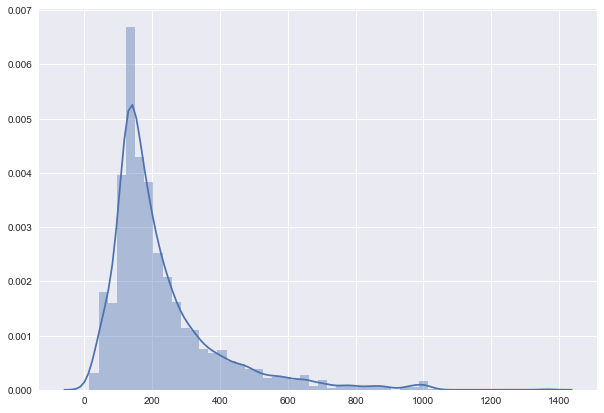

In [131]:
# let's get an idea of how long these documents are.

# looks like most of our documents are about 200 words, with a bit of a positive skew, with some docs
# as long as 1400 words.

lengths_train_neg = [len(doc[0].split(" ")) for doc in train_neg_text]

plt.figure(figsize=(10,7))
sns.distplot(lengths_train_neg, bins=50)

In [19]:
# let's put these into dataframes, turn them into a bag of words and do a little more EDA

train_0 = pd.DataFrame({
    'words': [doc[0] for doc in train_pos_text],
    'class': [1 for doc in train_pos_text],
})

train_1 = pd.DataFrame({
    'words': [doc[0] for doc in train_neg_text],
    'class': [0 for doc in train_neg_text],
})

train_df = pd.concat([train_0, train_1], axis=0)
train_df['class'].value_counts()

1    12500
0     1875
Name: class, dtype: int64

In [20]:
test_0 = pd.DataFrame({
    'words': [doc[0] for doc in valid_pos_text],
    'class': [1 for doc in valid_pos_text],
})

test_1 = pd.DataFrame({
    'words': [doc[0] for doc in valid_neg_text],
    'class': [0 for doc in valid_neg_text],
})

test_df = pd.concat([test_0, test_1], axis=0)
test_df['class'].value_counts()

1    6250
0    6250
Name: class, dtype: int64

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [22]:
# let's turn this into a bag of words

stopwords = stopwords.words('english')
stopwords.append('br')

count_vect = CountVectorizer(strip_accents='unicode', stop_words=stopwords)
train_bow  = count_vect.fit_transform(train_df.words)
columns    = count_vect.get_feature_names()

Let's look at what some of the top words are in the training set

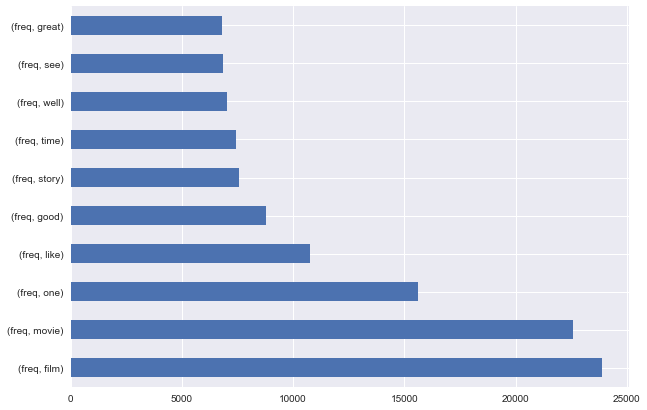

In [23]:
x_df       =  pd.DataFrame(train_bow.toarray(), columns=columns)
tf_df      =  pd.DataFrame(x_df.sum(), columns=["freq"])
tf_df.sort_values("freq", ascending=False).head(10).unstack().plot(kind='barh', figsize=(10,7))

In [128]:
len(x_df.columns)

58940

Looks like we have around 60,000 columns, which means about 60,000 vocabulary words in the training set.

# Simple Model

Let's start by doing a very simple model, we'll try doing random forest with the bag of words and evaluate it on the validation set.  RF is somewhat robust to class imbalance so it should be a decent starting place.



In [24]:
test_bow  = count_vect.transform(test_df.words)
x_df_test = pd.DataFrame(test_bow.toarray(), columns=columns)

In [15]:
# Let's first get our labels for training:

train_labels = []
test_labels = []

for name in sorted(os.listdir("./dataset/")[1:]):
    path = os.path.join("./dataset/", name)
    print path
    if os.path.isdir(path):
        # making 1 or 0 ohe label based on pos/neg
        if 'pos' in path:
            label_id = 1
        else:
            label_id = 0
            
        if 'train' in path:
            train_test_id = 1
        else:
            train_test_id = 0
        for fname in sorted(os.listdir(path)):
            if train_test_id == 1:
                train_labels.append(label_id)
            else:
                test_labels.append(label_id)

./dataset/train_neg
./dataset/train_pos
./dataset/valid_neg
./dataset/valid_pos


In [69]:
# The train labels go all 0s and then 1s, so let's just take a 50/50 split of 0 and 1 to balance it.

# The first 3750 will be a 50/50 split
x_df_downsample = x_df.iloc[0:3750, :]
train_labels_downsample = np.array(train_labels)[0:3750]

In [70]:
pd.Series(train_labels_downsample).value_counts()

1    1875
0    1875
dtype: int64

In [109]:
# Now let's shuffle the data

train_shuffle = np.random.choice(np.arange(len(x_df_downsample)), size=len(x_df_downsample), replace=False)
test_shuffle = np.random.choice(np.arange(len(x_df_test)), size=len(x_df_test), replace=False)

x_df_train_shuff = x_df_downsample.iloc[train_shuffle, :]
train_labels_shuff = np.array(train_labels_downsample)[train_shuffle]
x_df_test_shuff = x_df_test.iloc[test_shuffle, :]
test_labels_shuff = np.array(test_labels)[test_shuffle]

In [123]:
# now let's fit the random forest model

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=3, n_estimators=100, verbose=1)
rf.fit(x_df_train_shuff, train_labels_shuff)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=1, warm_start=False)

In [124]:
rf.score(x_df_train_shuff, train_labels_shuff)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


0.73493333333333333

In [125]:
# We're super overfit

In [126]:
rf.score(x_df_test_shuff, test_labels_shuff)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


0.48912

Wow so our first model is doing worse than baseline.  I think our problem here is that there are just way too many features in the training matrix because we're including all 50000 words.  Let's see if we can beat that with some neural networks.  Probably something else is going wrong here but considering that the point is not to make this model work let's move on.

## Neural Network

Let's see if we can start building a neural network model with an architecture similar to that described in the paper

In [136]:
# first we need to create an embedding layer that will map the vocabulary to pretrained glove vectors
import sys

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
train_test = []

for name in sorted(os.listdir("./dataset/")[1:]):
    path = os.path.join("./dataset/", name)
    print path
    if os.path.isdir(path):
        
        # making 1 or 0 ohe label based on pos/neg
        if 'pos' in path:
            label_id = 1
        else:
            label_id = 0
        
        # adding train/test labels so we can split up the data into train and validation later
        if 'train' in path:
            train_test_id = 1
        else:
            train_test_id = 0
            
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            fpath = os.path.join(path, fname)
            if sys.version_info < (3,):
                f = open(fpath)
            else:
                f = open(fpath, encoding='latin-1')
            t = f.read()
            i = t.find('\n\n')  # skip header
            if 0 < i:
                t = t[i:]
            texts.append(t)
            f.close()
            labels.append(label_id)
            train_test.append(train_test_id)

print('Found %s texts.' % len(texts))

./dataset/train_neg
./dataset/train_pos
./dataset/valid_neg
./dataset/valid_pos
Found 26875 texts.


Next let's tokenize the words using keras' Tokenizer and pad them to bee the same length.

In [137]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# going to limit to the 20000 most common words for efficiency's sake
tokenizer = Tokenizer(nb_words=20000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# going to truncate our texts at 250 words, based on the histogram of document lengths
data = pad_sequences(sequences, maxlen=250)
labels = np.array(labels).reshape((len(labels), 1))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

//anaconda/lib/python2.7/site-packages/keras/preprocessing/text.py:89: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 93318 unique tokens.
('Shape of data tensor:', (26875, 250))
('Shape of label tensor:', (26875, 1))


Now let's go ahead and do a train test split, according to how the data is divided up in the directories provided.

In [138]:
# splitting data into train and test

train_indices = [i for (i, label) in enumerate(train_test) if label == 1]
test_indices = [i for (i, label) in enumerate(train_test) if label == 0]

x_train = data[train_indices]
y_train = np.array(labels)[train_indices]
x_val = data[test_indices]
y_val = np.array(labels)[test_indices]

In [139]:
# let's shuffle up the train and test sets

train_shuffle = np.random.choice(np.arange(len(x_train)), size=len(x_train), replace=False)
test_shuffle = np.random.choice(np.arange(len(x_val)), size=len(x_val), replace=False)

x_train_shuff = x_train[train_shuffle]
y_train_shuff = y_train[train_shuffle]
x_val_shuff = x_val[test_shuffle]
y_val_shuff = y_val[test_shuffle]

### Preparing the Embedding layer

Now we'll create a mapping dictionary based on pretrained glove vectors.  We'll just go ahead and use the 200 dimensional word vectors to be more in line with the article. They use the 300 dimensional vecotrs and project those to 200 dimensions, but why not just use pretrained 200 dimensional vectors? Seems better to me.

In [140]:
embeddings_index = {}

with open(os.path.join("../glove.6B/", 'glove.6B.200d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# embedding dimension is the dimensionality of the glove vectors

embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=250,
                            trainable=False)

Found 400000 word vectors.


# Building A Simple Model

First I want to start out by building a simpler model, in order to get a baseline and make sure that the data is set up right.  Training the model described in the paper is going to be very slow, so we can at least verify that everything is in place using a simpler model before making that investment.

I'm also just going to try training this on the validation data, because that doesn't have the class imbalance that we see in the training data.

In [133]:
from keras.optimizers import Adadelta
from keras.models import Model
from keras.layers import Dense, Flatten, concatenate, Dropout, Input, Merge

In [267]:
from keras.models import Sequential

# create the model
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=250,
                            trainable=False))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(250, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [161]:
# Let's just fit on the test data, with an 80/20 train/test split

x_val_shuff_train = x_val_shuff[:10000]
y_val_shuff_train = y_val_shuff[:10000]
x_val_shuff_test = x_val_shuff[10000:]
y_val_shuff_test = y_val_shuff[10000:]

In [245]:
model.fit(x_val_shuff_train, y_val_shuff_train, validation_data=(x_val_shuff_test, y_val_shuff_test),
          epochs=1, batch_size=128)
# model.save('./full_v8_model.h5')

Train on 10000 samples, validate on 2500 samples
Epoch 1/1
10000/10000 [==============================] - 275s - loss: 0.4904 - acc: 0.7400 - val_loss: 0.5531 - val_acc: 0.7180


In [246]:
model.evaluate(x_train, y_train)

14375/14375 [==============================] - 106s   


[0.54304581208851022, 0.7350956521780595]

While this model isn't performing great, it is at least doing better than baseline (.5) on the validation data and isn't overfitting.  It at least seems like our data is set up well enough to move on to the more complex model.

### Bootstrapping the Training Data

Because there's a pretty large class imbalance in the training data, I'm going to go ahead and try bootstrapping the negative class so we can get up to a 50/50 split.  If we do this all the way up to 10000 and 10000, we'll be resampling the negative class each around 10 times, which is probably going to cause overfitting, so instead we'll downsample the positive class, and then resample the negative class to match.

I'll then go ahead and try training the simple model on that data to see if we can at least beat baseline and avoid overfitting the data.  Then we'll move on to the complex model.

In [141]:
y_train_neg_indices = [i for i, value in enumerate(y_train_shuff) if value[0] == 0]
y_train_pos_indices = [i for i, value in enumerate(y_train_shuff) if value[0] == 1]

In [142]:
print "negative class total: ", len(y_train) - sum(y_train)
print "positive class total: ", sum(y_train)

negative class total:  [1875]
positive class total:  [12500]


In [143]:
# Getting a list of sample indices of the negative class, so that split is 50/50 pos/neg

# We'll set the size to 1125, so we have 3000/3000
neg_bootstrap_indices = list(np.random.choice(y_train_neg_indices, size=1125, replace=False))

In [144]:
# now let's select 3000 random indices from the positive indices
pos_bootstrap_indices = list(np.random.choice(y_train_pos_indices, size=3000, replace=False))

In [145]:
# If we add together the y_train negative, bootstrap, and positive bootstrap indices, we'll have our 6000 indices

bootstrap_indices = neg_bootstrap_indices + pos_bootstrap_indices + y_train_neg_indices

# getting a bootstrapped training set that is a 50/50 split
x_train_bootstrap = x_train_shuff[bootstrap_indices]
y_train_bootstrap = y_train_shuff[bootstrap_indices]

In [146]:
# We now have a 50/50 split

sum(y_train_bootstrap)/float(len(y_train_bootstrap))

array([ 0.5])

### Training Bootstrap Data on Simple Model

Let's try training the simple model from earlier with the same data to confirm that our sampling process isn't messing with the model's ability to generalize well and avoid overfitting.

In [263]:
# Let's reset the model first.
model.reset_states()

In [266]:
model.fit(x_train_bootstrap, y_train_bootstrap, validation_data=(x_val_shuff, y_val_shuff),
          epochs=3, batch_size=128)

Train on 6000 samples, validate on 12500 samples
Epoch 1/3
6000/6000 [==============================] - 264s - loss: 1.0788 - acc: 0.5298 - val_loss: 0.6888 - val_acc: 0.5818
Epoch 2/3
6000/6000 [==============================] - 280s - loss: 0.6497 - acc: 0.6387 - val_loss: 0.6695 - val_acc: 0.6045
Epoch 3/3
6000/6000 [==============================] - 221s - loss: 0.4922 - acc: 0.7603 - val_loss: 0.5930 - val_acc: 0.6893


Seems like we're overfitting a bit after 3 epochs.  Let's try using all the data, but with a 85:10 class weight.

In [269]:
model.reset_states()

class_weights = {
    1: 1.0,
    0: 8.5,
}

model.fit(x_train_shuff, y_train_shuff, validation_data=(x_val_shuff, y_val_shuff),
          epochs=3, batch_size=128, class_weight = class_weights)

Train on 14375 samples, validate on 12500 samples
Epoch 1/3
14375/14375 [==============================] - 510s - loss: 2.1373 - acc: 0.3569 - val_loss: 0.7409 - val_acc: 0.5826
Epoch 2/3
14375/14375 [==============================] - 445s - loss: 1.3939 - acc: 0.5039 - val_loss: 0.8414 - val_acc: 0.5696
Epoch 3/3
14375/14375 [==============================] - 416s - loss: 1.1131 - acc: 0.7656 - val_loss: 0.6425 - val_acc: 0.6194


Looks like we actually overfit the model more by using weighting as opposed to resampling and using a smaller training set.  I'm going to go ahead and train the full model on the sampled data.

Also, these are already taking a while to train, and using a smaller training set will make training more efficient.

# Building The Complex Model

This is after about 7 epochs, looks like we're starting to overfit, and the val_loss went up between these last two epochs.  Let's check out a classification report for this model on the validation data.

In [168]:
sequence_input = Input(shape=(250,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# After the embedded sequences we need eight distinct softmax dense layers.

# Not sure that the coding on this part is right. 

# Seems like what they're doing is a tanh activated dense layer, then doing a softmax function on the output

S_1 = Dense(250, activation='tanh')(embedded_sequences)
S_1 = Dense(250, activation='linear')(S_1)
S_1 = Dense(250, activation="softmax")(S_1)
S_1 = Flatten()(S_1)

S_2 = Dense(250, activation='tanh')(embedded_sequences)
S_2 = Dense(250, activation='linear')(S_2)
S_2 = Dense(250, activation="softmax")(S_2)
S_2 = Flatten()(S_2)

S_3 = Dense(250, activation='tanh')(embedded_sequences)
S_3 = Dense(250, activation='linear')(S_3)
S_3 = Dense(250, activation="softmax")(S_3)
S_3 = Flatten()(S_3)

S_4 = Dense(250, activation='tanh')(embedded_sequences)
S_4 = Dense(250, activation='linear')(S_4)
S_4 = Dense(250, activation="softmax")(S_4)
S_4 = Flatten()(S_4)

S_5 = Dense(250, activation='tanh')(embedded_sequences)
S_5 = Dense(250, activation='linear')(S_5)
S_5 = Dense(250, activation="softmax")(S_5)
S_5 = Flatten()(S_5)

S_6 = Dense(250, activation='tanh')(embedded_sequences)
S_6 = Dense(250, activation='linear')(S_6)
S_6 = Dense(250, activation="softmax")(S_6)
S_6 = Flatten()(S_6)

S_7 = Dense(250, activation='tanh')(embedded_sequences)
S_7 = Dense(250, activation='linear')(S_7)
S_7 = Dense(250, activation="softmax")(S_7)
S_7 = Flatten()(S_7)

S_8 = Dense(250, activation='tanh')(embedded_sequences)
S_8 = Dense(250, activation='linear')(S_8)
S_8 = Dense(250, activation="softmax")(S_8)
S_8 = Flatten()(S_8)

# v_1 IS just S_1
v_1 = S_1

# v_2 should be a concatenation of v_1 and S_2
v_2_concat = concatenate([v_1, S_2])
v_2 = Dense(128, activation='tanh')(v_2_concat)

# v_3 should be a concatenation of v_1, v_2, and S_3
v_3_concat = concatenate([v_1, v_2, S_3])
v_3 = Dense(128, activation='tanh')(v_3_concat)

# v_3 should be a concatenation of v_1, v_2, and S_3
v_3_concat = concatenate([v_1, v_2, S_3])
v_3 = Dense(128, activation='tanh')(v_3_concat)

# v_4 should be a concatenation of v_1, v_2, and S_3
v_4_concat = concatenate([v_1, v_2, v_3, S_4])
v_4 = Dense(128, activation='tanh')(v_4_concat)

# v_5 should be a concatenation of v_1, v_2, v_3, v_4, and S_3
v_5_concat = concatenate([v_1, v_2, v_3, v_4, S_5])
v_5 = Dense(128, activation='tanh')(v_5_concat)

v_6_concat = concatenate([v_1, v_2, v_3, v_4, v_5, S_6])
v_6 = Dense(128, activation='tanh')(v_6_concat)

v_7_concat = concatenate([v_1, v_2, v_3, v_4, v_5, v_6, S_7])
v_7 = Dense(128, activation='tanh')(v_7_concat)

# v_8 again just is s_8
v_8 = S_8


# MERGING ALL THE LAYERS
concat_layer = concatenate([v_1, v_2, v_3, v_4, v_5, v_6, v_7, v_8])
perceptron_1 = Dense(128, activation='softmax')(concat_layer)
dropout = Dropout(.2)(perceptron_1)
preds = Dense(1, activation='sigmoid')(dropout)

# They use adadelta optimizer, with a really small learning rate.  I'm going to up it a bit for efficacy's sake.
adadelta = Adadelta(lr=.5)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy', optimizer=adadelta, metrics=['accuracy'])

In [169]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

# Let's just start with 5 epochs, and see if we overfit at all.

model.fit(x_train_bootstrap, y_train_bootstrap, validation_data=(x_val_shuff, y_val_shuff),
          epochs=5, batch_size=50, callbacks=[early_stopping])

Train on 6000 samples, validate on 12500 samples
Epoch 1/5
1500/6000 [======>.......................] - ETA: 455s - loss: 0.6930 - acc: 0.5253

KeyboardInterrupt: 

In [164]:
# Well holy shit is this sucking.  Let's try the old simple model

from keras.models import Sequential

# create the model
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=250,
                            trainable=False))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(250, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [165]:
model.fit(x_train_bootstrap, y_train_bootstrap, validation_data=(x_val_shuff, y_val_shuff),
          epochs=5, batch_size=50, callbacks=[early_stopping])

Train on 6000 samples, validate on 12500 samples
Epoch 1/5
6000/6000 [==============================] - 42s - loss: 0.7928 - acc: 0.5613 - val_loss: 0.6381 - val_acc: 0.6445
Epoch 2/5
6000/6000 [==============================] - 50s - loss: 0.5612 - acc: 0.6822 - val_loss: 0.6031 - val_acc: 0.6710
Epoch 3/5
6000/6000 [==============================] - 45s - loss: 0.4320 - acc: 0.7798 - val_loss: 0.7028 - val_acc: 0.6663
Epoch 4/5
6000/6000 [==============================] - 42s - loss: 0.3558 - acc: 0.8250 - val_loss: 0.7608 - val_acc: 0.5966
Epoch 5/5
6000/6000 [==============================] - 42s - loss: 0.2934 - acc: 0.8523 - val_loss: 0.6329 - val_acc: 0.6927


## Evaluation

In [277]:
from sklearn.metrics import classification_report

y_val_pred = model.predict(x_val_shuff)

In [284]:
# We have to convert values to 0 and 1 from predictions.
y_val_pred_bin = [1 if y >= .5 else 0 for y in y_val_pred]

print classification_report(y_val_shuff, y_val_pred_bin)

             precision    recall  f1-score   support

          0       0.76      0.73      0.74      6250
          1       0.74      0.78      0.76      6250

avg / total       0.75      0.75      0.75     12500



Looks like there's a pretty nice balance between precision and recall.  Recall is a bit better on the positive class, and precision is a bit better on the negative class.

### ROC Curve

Let's evaluate performance with an ROC curve as well and look at area under the curve.

In [293]:
from sklearn.metrics import roc_curve, auc

In [294]:
fpr, tpr, thresholds = roc_curve(y_val_shuff, y_val_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

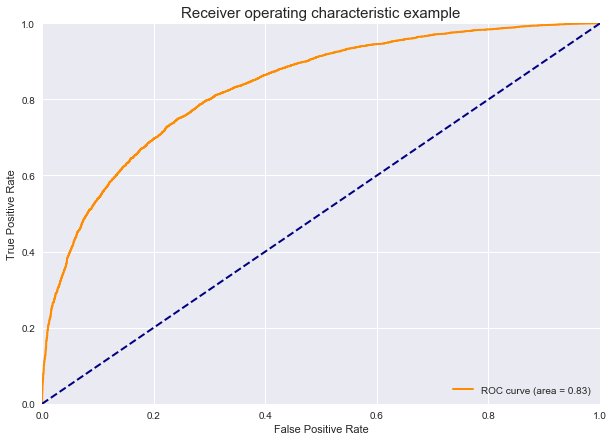

In [298]:
plt.figure(figsize=(10,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example', size=15)
plt.legend(loc="lower right")
plt.show()

Strong AUC score at .83. We’d want to compare this against other models to get a better idea of its competitiveness

Let's also print out a final summary of the model we used:

In [283]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_27 (InputLayer)            (None, 2000)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 2000, 200)     18663800    input_27[0][0]                   
____________________________________________________________________________________________________
dense_143 (Dense)                (None, 2000, 128)     25728       embedding_1[26][0]               
____________________________________________________________________________________________________
flatten_36 (Flatten)             (None, 256000)        0           dense_143[0][0]                  
___________________________________________________________________________________________

## Next steps

There are a few clear areas for improvement in the analysis here, and for evaluating the performance of the end-to-end MVN architecture:
1. Train on a larger corpus, with less class imbalance.
2. Replace first set of dense layers with convolutional layers, which may allow the next set of view layers to pick out more meaning.
3. Lower the learning rate to what they used in the paper, and set this up to run on a GPU.  Would likely achieve higher performance.
